In [168]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, \
        math, os, sys

from itertools import repeat
from dataclasses import dataclass

from typing import *

In [169]:
df = pd.read_csv('double_blink.csv')

In [170]:
SENSORS = ['TP9', 'AF7', 'AF8', 'TP10']

In [171]:
def rolling_stats(data, window_size, min_std: float = 10.0):
    global max_std_ever
    
    kernel = np.ones(window_size) / window_size
    
    # Calculate rolling mean
    mean = np.convolve(data, kernel, mode='same')
    
    # Calculate rolling std
    data_squared = data ** 2
    mean_squared = np.convolve(data_squared, kernel, mode='same')
    std = np.sqrt(mean_squared - mean ** 2)

    std[std < min_std] = min_std

    return mean, std

In [172]:
def plot_sensors(
    data: pd.DataFrame, 
    r: slice = slice(0, -1), 
    history_len: int = 200, 
    trigger_stds: float = 1.75, 
    min_trigger_len: int = 5, 
    min_stretch_gap: int = 10,
    show_annotations: bool = True,
    show_highlights: bool = True,
    show_event_highlights: bool = True,
    show_event_tags: bool = True,
) -> 'Axis':
    
    fig, axs = plt.subplots(len(SENSORS), 1, figsize=(12, 2.5 * len(SENSORS)))
    
    axs = axs.flatten()

    sensor_trigger_history = []

    # Generate trigger bounds
    for s in SENSORS:

        mean, std = rolling_stats(
                data[s].to_numpy()[r], window_size=history_len
            )

        sensor_trigger_history.append(
            (
                mean - std * trigger_stds, mean + std * trigger_stds
            )
        )

    # Adjust time stamps to zero
    ts = data['timestamps'][r] - data['timestamps'][r].min()
    
    # Color palette for different sensors
    colors = plt.cm.tab10(range(len(SENSORS)))
    
    for i, (s, sh, ax) in enumerate(zip(SENSORS, sensor_trigger_history, axs)):

        d = data[s][r]

        up_highlight = np.full_like(d, fill_value=np.nan)
        down_highlight = np.full_like(d, fill_value=np.nan)

        # Highlight sections outside of bounds
        min_b, max_b = sh

        up_highlight[max_b < d] = d[max_b < d]
        down_highlight[min_b > d] = d[min_b > d]
        
        ax.plot(
            ts,
            d,
            color=colors[i],
            linewidth=2,
            alpha=0.8
        )

        ax.plot(ts, min_b, color='red', alpha=0.5, linestyle='--', linewidth=1)
        ax.plot(ts, max_b, color='blue', alpha=0.5, linestyle='--', linewidth=1)

        # Plot green highlights (optional)
        if show_highlights:
            ax.plot(ts, up_highlight, color='green', linewidth=2.5)
            ax.plot(ts, down_highlight, color='green', linewidth=2.5)
        
        # Add annotations (optional)
        if show_annotations:
            # Find continuous stretches of non-NaN values
            def find_stretches(highlight_array, min_len, min_gap):
                """Find continuous stretches of non-NaN values >= min_len"""
                stretches = []
                start = None
                
                for i in range(len(highlight_array)):
                    if not np.isnan(highlight_array[i]):
                        if start is None:
                            start = i
                    else:
                        if start is not None:
                            length = i - start
                            if length >= min_len:
                                stretches.append((start, i - 1, length))
                            start = None
                
                # Handle case where stretch extends to end
                if start is not None:
                    length = len(highlight_array) - start
                    if length >= min_len:
                        stretches.append((start, len(highlight_array) - 1, length))
                
                # Filter out stretches that are too close together
                if len(stretches) <= 1:
                    return stretches
                
                filtered_stretches = [stretches[0]]
                for start_idx, end_idx, length in stretches[1:]:
                    prev_end = filtered_stretches[-1][1]
                    # Check if gap between previous stretch end and current stretch start is large enough
                    if start_idx - prev_end >= min_gap:
                        filtered_stretches.append((start_idx, end_idx, length))
                    else:
                        # Merge with previous stretch if too close
                        prev_start = filtered_stretches[-1][0]
                        new_length = end_idx - prev_start + 1
                        filtered_stretches[-1] = (prev_start, end_idx, new_length)
                
                return filtered_stretches
            
            # Add tags for upper threshold violations
            up_stretches = find_stretches(up_highlight, min_trigger_len, min_stretch_gap)
            for start_idx, end_idx, length in up_stretches:
                ax.text(
                    ts.iloc[start_idx], 
                    d.iloc[start_idx],
                    f'▲ HIGH ({length})',
                    fontsize=9,
                    fontweight='bold',
                    color='darkred',
                    ha='left',
                    va='bottom',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='red', alpha=0.8)
                )
            
            # Add tags for lower threshold violations
            down_stretches = find_stretches(down_highlight, min_trigger_len, min_stretch_gap)
            for start_idx, end_idx, length in down_stretches:
                ax.text(
                    ts.iloc[start_idx],
                    d.iloc[start_idx],
                    f'▼ LOW ({length})',
                    fontsize=9,
                    fontweight='bold',
                    color='darkblue',
                    ha='left',
                    va='top',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='blue', alpha=0.8)
                )

        # Styling
        ax.set_ylabel(s, fontsize=11, fontweight='bold')
        ax.set_xlabel('Time (s)' if i == len(SENSORS) - 1 else '', fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Format x-axis for better readability
        ax.tick_params(axis='both', labelsize=9)
        
    plt.suptitle('Sensor Data with Anomaly Detection', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    return axs

def plot_deltas(
        data: pd.DataFrame,
        r: slice = slice(0, -1),
        prev_n: int = 10,
        **kwargs,
    ) -> 'Axis':

    channels = data[SENSORS].to_numpy()

    # get deltas, -mean prev_n
    kernel = -np.ones((prev_n)) / prev_n

    # Add self as 1
    kernel = np.pad(kernel, (0, 1), mode='constant', constant_values=1)

    kernel = np.pad(kernel, (0, prev_n), mode='constant', constant_values=0)

    values = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), 
                              axis=0, arr=channels)

    new_df = df.copy()

    new_df[SENSORS] = values

    axs = plot_sensors(new_df, **kwargs)

    return axs

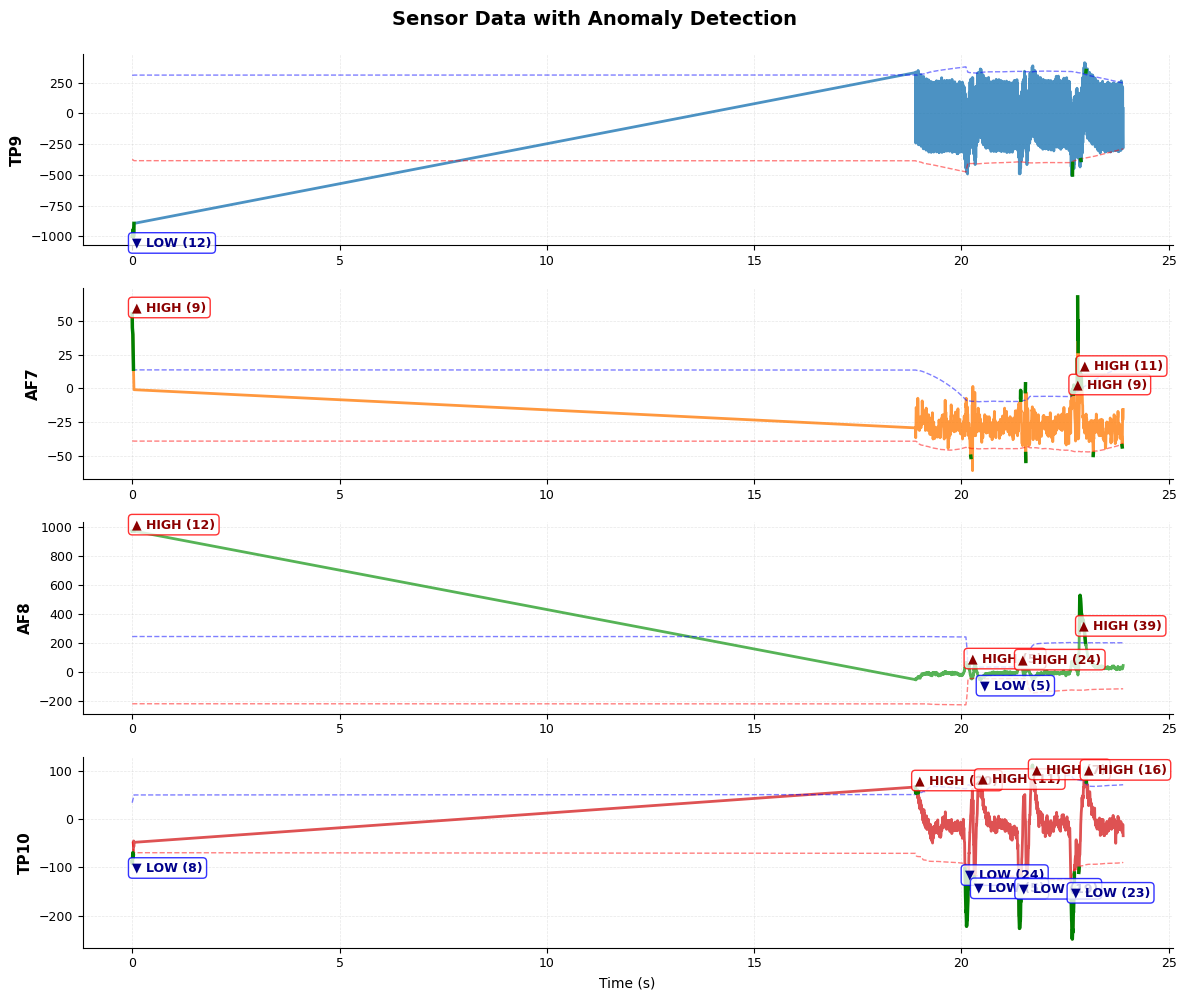

In [173]:
start: int = 0
bound: int = len(df)

axs = plot_sensors(df, r=slice(start, start + bound), history_len=bound // 2, show_annotations=True, show_highlights=True)

In [174]:
@dataclass
class EventInProgress:

    start: float
    
    sensor: str

    location: Literal['positive', 'negative']

    # Count so can have some limit
    interupts: int

    # In frames so we can track
    current_length: int

@dataclass
class CompletedEvent:

    start: float
    end: float
    total_time: float

    sensor: str

    location: Literal['positive', 'negative']

    # Count so can have some limit
    interupts: int

    # In frames so we can track
    frame_length: int

@dataclass
class SensorCurrent:

    sensor: str
    value: float

def handle_event_snapshot(current: List[SensorCurrent], events: List[EventInProgress]) -> Tuple[List[EventInProgress], List[CompletedEvent]]:
    pass

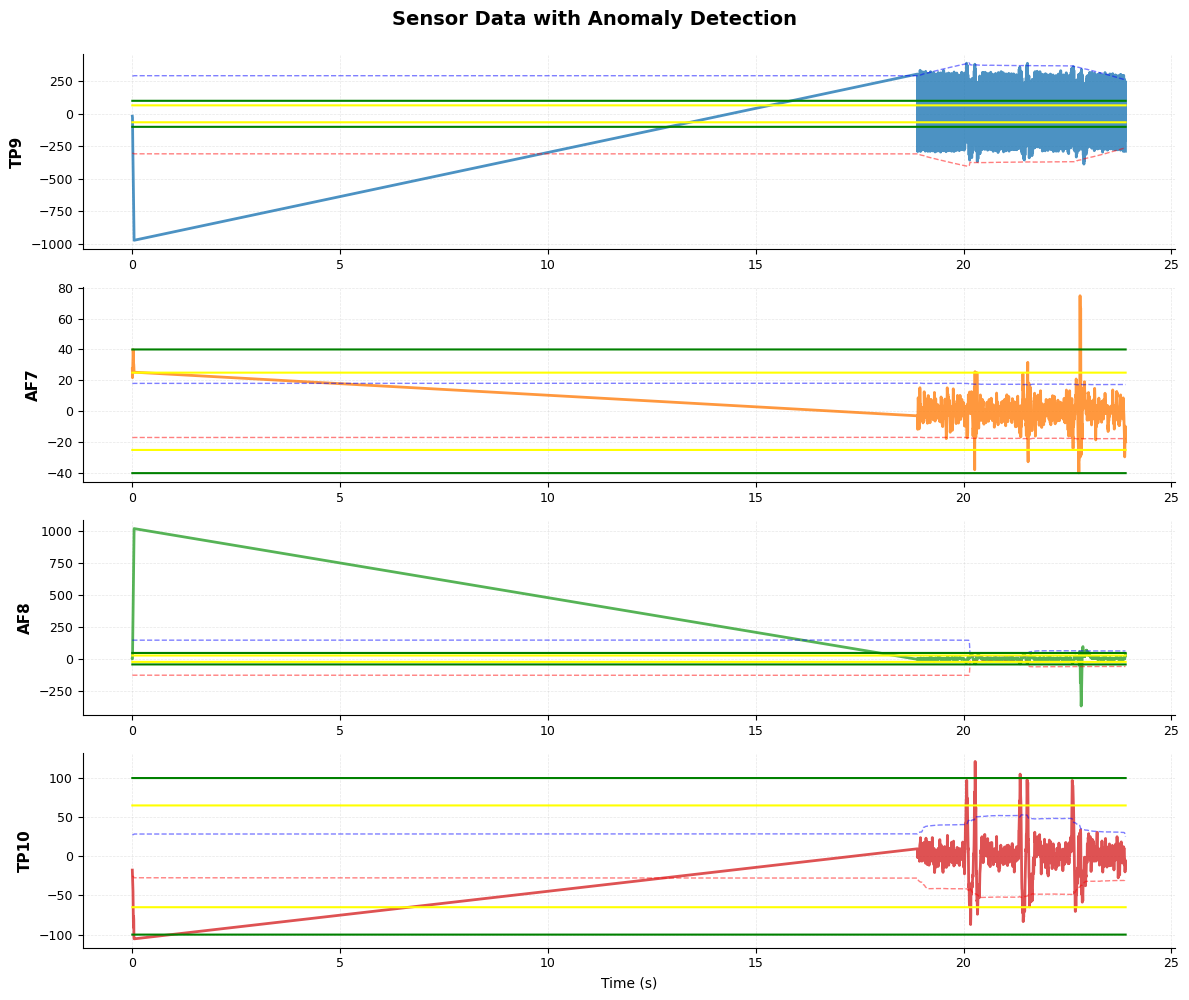

In [175]:
start: int = 0
bound: int = len(df)

r = slice(start, start + bound)

LARGE_TRIGGERS = {
    'TP9' : (-100, 100),
    'AF7' : (-40, 40),
    'AF8' : (-45, 45),
    'TP10' : (-100, 100),
}

SMALL_TRIGGERS = {
    'TP9' : (-65, 65),
    'AF7' : (-25, 25),
    'AF8' : (-25, 25),
    'TP10' : (-65, 65),
}

# To detect static
BOUNDS = {
    'TP9' : (-500, 500),
    'AF7' : (-500, 500),
    'AF8' : (-500, 500),
    'TP10' : (-500, 500),
}


axs = plot_deltas(df, r=r, history_len=bound // 2, show_annotations=False, show_highlights=False)
for (s, ax) in zip(SENSORS, axs):

    for b in LARGE_TRIGGERS[s]:

        ax.plot(df['timestamps'][r] - df['timestamps'][r].min(), list(repeat(b, times=len(df))), color='green')

    for b in SMALL_TRIGGERS[s]:

        ax.plot(df['timestamps'][r] - df['timestamps'][r].min(), list(repeat(b, times=len(df))), color='yellow')

    # for b in BOUNDS[s]:

    #     ax.plot(df['timestamps'][r] - df['timestamps'][r].min(), list(repeat(b, times=len(df))), color='red')
